In [4]:
import os
import numpy as np
import SimpleITK as sitk
from skimage import measure
from scipy.ndimage import label

import glob
from time import time
import matplotlib.pyplot as plt
import copy
import math
import argparse
import random
import warnings
import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision

from dataset.dataset import Dataset

from net import Unet
from utilities.utils import count_params
import joblib
import imageio

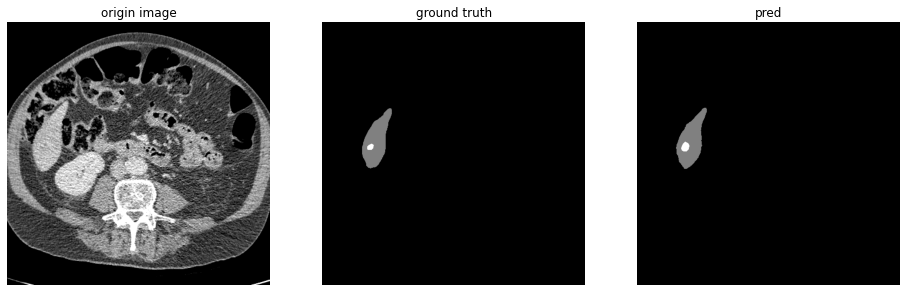

In [16]:
# -*- coding: utf-8 -*-
log = pd.DataFrame(index=[], columns=[
        'file', 'dice_liver', 'dice_tumor'
])

#import ttach as tta
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

test_ct_path = 'LITS2017/CT/volume-129.nii'   #需要预测的CT图像
seg_result_path = 'LITS2017/seg/segmentation-129.nii' #需要预测的CT图像标签，如果要在线提交codelab，需要先得到预测过的70例肝脏标签

model = Unet.U_Net()

model = torch.nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('models/Unet/2021-06-19-22-29-03/epoch154-0.9404-0.6316_model.pth'))

model.eval()
# model = tta.SegmentationTTAWrapper(model, tta.aliases.d4_transform(), merge_mode='mean')

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

start = time()


ct = sitk.ReadImage(test_ct_path, sitk.sitkInt16)
ct_array = sitk.GetArrayFromImage(ct)

mask = sitk.ReadImage(seg_result_path, sitk.sitkUInt8)
mask_array = sitk.GetArrayFromImage(mask)

ct_array[ct_array > 200] = 200
ct_array[ct_array < -200] = -200

ct_array = ct_array.astype(np.float32)
ct_array = ct_array / 200

# 找到肝脏区域开始和结束的slice，并各向外扩张slice
z = np.any(mask_array, axis=(1, 2))
start_slice, end_slice = np.where(z)[0][[0, -1]]

start_slice = max(0, start_slice - 10)
end_slice = min(mask_array.shape[0]-1, end_slice + 10)

ct_crop = ct_array[start_slice:end_slice+1,32:480,32:480]
mask_crop = mask_array[start_slice:end_slice+1, :, :]

ct_array = ct_array[start_slice:end_slice+1,32:480,32:480]
slice_predictions = np.zeros((ct_array.shape[0],512,512),dtype=np.int16)

with torch.no_grad():
    for n_slice in range(ct_crop.shape[0]-3):
        ct_tensor = torch.FloatTensor(ct_crop[n_slice: n_slice + 3]).cuda()
        ct_tensor = ct_tensor.unsqueeze(dim=0)
        # print('ct_tensor',ct_tensor.shape,n_slice)
        output = model(ct_tensor)
        output = torch.sigmoid(output).data.cpu().numpy()
        probability_map = np.zeros([1, 448, 448], dtype=np.uint8)
        #预测值拼接回去
        # i = 0
        for idz in range(output.shape[1]):
            for idx in range(output.shape[2]):
                for idy in range(output.shape[3]):
                    if (output[0,0, idx, idy] > 0.65):
                        probability_map[0, idx, idy] = 1        
                    if (output[0,1, idx, idy] > 0.5):
                        probability_map[0, idx, idy] = 2

        slice_predictions[n_slice,32:480,32:480] = probability_map
        a = slice_predictions.copy()
        seg_slice = a[n_slice]
        seg_slice[seg_slice==1] = 0
        b = mask_crop.copy()
        seg_slice_b = b[n_slice]
        seg_slice_b[seg_slice_b==1] = 0
        if len(np.nonzero(seg_slice)[0]) > 0 and len(np.nonzero(seg_slice_b)[0]) > 0:
            plt.figure(figsize=(16,8))
            plt.subplot(1,3,1)
            plt.imshow(ct_tensor.cpu()[0,0,:,:], cmap ='gray')
            plt.title('origin image')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(mask_crop[n_slice], cmap ='gray')
            plt.title('ground truth')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(slice_predictions[n_slice,:,:,], cmap ='gray')
            plt.title('pred')
            plt.axis('off')
            plt.show()
            break        

In [5]:
log_path = '/home/hanyang/workspace/LITS2017/LITS2017-main1/models/Unet/2021-06-19-22-29-03/log.csv'
logs = pd.read_csv(log_path)
logs

,epoch,lr,loss,iou,dice_1,dice_2,val_loss,val_iou,val_dice_1,val_dice_2
0,0.0,0.0001,1.092967,0.201124,0.333098,0.004194,0.953918,0.285543,0.446435,0.003723
1,1.0,0.0001,0.887308,0.363931,0.533808,0.003144,0.833664,0.431801,0.603408,0.002658
2,2.0,0.0001,0.800930,0.478026,0.638683,0.002784,0.769651,0.523817,0.676010,0.002998
3,3.0,0.0001,0.746257,0.559169,0.700523,0.005963,0.719560,0.606403,0.739190,0.016181
4,4.0,0.0001,0.699672,0.628824,0.751510,0.039932,0.673797,0.672251,0.785899,0.072178
...,...,...,...,...,...,...,...,...,...,...
192,192.0,0.0001,0.403149,0.901272,0.943148,0.617443,0.415294,0.898400,0.940615,0.605739
193,193.0,0.0001,0.403282,0.901412,0.943228,0.616629,0.414496,0.899416,0.941387,0.613641
194,194.0,0.0001,0.402768,0.901915,0.943523,0.621802,0.414423,0.899182,0.941048,0.622039
195,195.0,0.0001,0.402667,0.901584,0.943292,0.620962,0.414438,0.899036,0.940878,0.631900


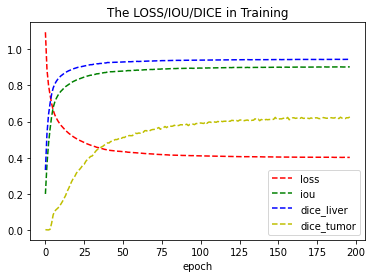

In [14]:
plt.plot(logs['epoch'],logs['loss'],'--r',label='loss')
plt.plot(logs['epoch'],logs['iou'],'--g',label='iou')
plt.plot(logs['epoch'],logs['dice_1'], '--b',label='dice_liver')
plt.plot(logs['epoch'],logs['dice_2'], '--y',label='dice_tumor')
plt.title('The LOSS/IOU/DICE in Training')
plt.xlabel('epoch')
plt.legend()
plt.show()

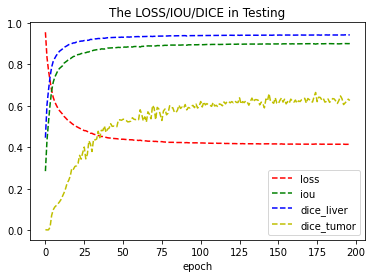

In [15]:
plt.plot(logs['epoch'],logs['val_loss'],'--r',label='loss')
plt.plot(logs['epoch'],logs['val_iou'],'--g',label='iou')
plt.plot(logs['epoch'],logs['val_dice_1'], '--b',label='dice_liver')
plt.plot(logs['epoch'],logs['val_dice_2'], '--y',label='dice_tumor')
plt.title('The LOSS/IOU/DICE in Testing')
plt.xlabel('epoch')
plt.legend()
plt.show()